# GANs

This is a _gentle_ introduction to GANs using [GANs from Scratch 1: A deep introduction. With code in PyTorch and TensorFlow](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f).


In [ ]:
# Imports and setup: bring in network classes, logging helper, and PyTorch libs
from utils import Logger, DiscriminatorNet, GeneratorNet
from IPython import display
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

# Local folder to store MNIST dataset and related torch files
DATA_FOLDER = "./torch_data/VGAN/MNIST"

### Data Acquisition


In [ ]:
# Prepare MNIST dataset with normalization and convert to tensors
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]
    )
    # store downloaded dataset under DATA_FOLDER/dataset
    out_dir = "{}/dataset".format(DATA_FOLDER)
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)


# load the dataset into memory (or download if missing)
data = mnist_data()

# Create loader with data, so that we can iterate over it in batches
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

# Number of minibatches per epoch
num_batches = len(data_loader)

## Networks


In [ ]:
# Helpers to reshape MNIST images (28x28) to flat vectors and back
def images_to_vectors(images):
    # flatten batch of images to shape (batch_size, 784)
    return images.view(images.size(0), 784)


def vectors_to_images(vectors):
    # reshape flat vectors back to (batch_size, 1, 28, 28) for display
    return vectors.view(vectors.size(0), 1, 28, 28)

In [ ]:
# Random noise generator: input to the generator model
def noise(size):
    """
    Generates a 1-d vector of gaussian sampled random values
    """
    n = Variable(torch.randn(size, 100))
    # move noise to GPU if available
    if torch.cuda.is_available():
        return n.cuda()
    return n

In [ ]:
# Instantiate networks and move them to GPU if available
discriminator = DiscriminatorNet()
generator = GeneratorNet()
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

## Optimization


In [ ]:
# Training setup: optimizers, loss, and training hyperparameters
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

# Binary cross-entropy used because discriminator outputs probability of real/fake
loss = nn.BCELoss()

# How many times to update discriminator per generator update (commonly 1)
d_steps = 1  # In Goodfellow et. al 2014 this variable is assigned to 1

# Number of epochs to train over the dataset
num_epochs = 200

## Training


In [ ]:
# Helper functions that produce label tensors for real (1) and fake (0) targets
def real_data_target(size):
    """
    Tensor containing ones, with shape = size
    """
    data = Variable(torch.ones(size, 1))
    # move to GPU if available
    if torch.cuda.is_available():
        return data.cuda()
    return data


def fake_data_target(size):
    """
    Tensor containing zeros, with shape = size
    """
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available():
        return data.cuda()
    return data

In [ ]:
# Training step implementations for discriminator and generator
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()

    # 1.1 Train on Real Data: discriminator should predict 1 for real samples
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data: discriminator should predict 0 for fake samples
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()

    # 1.3 Update weights with gradients
    optimizer.step()

    # Return error and raw predictions for logging
    return error_real + error_fake, prediction_real, prediction_fake


def train_generator(optimizer, fake_data):
    # 2. Train Generator: goal is to fool discriminator into predicting real (1)
    # Reset gradients
    optimizer.zero_grad()
    # Evaluate discriminator on fake data
    prediction = discriminator(fake_data)
    # Calculate error against 'real' labels so generator learns to produce realistic samples
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

## Generate Samples for Testing


In [ ]:
# Prepare fixed noise used for evaluating generator progress across iterations
num_test_samples = 16
test_noise = noise(num_test_samples)

## Training


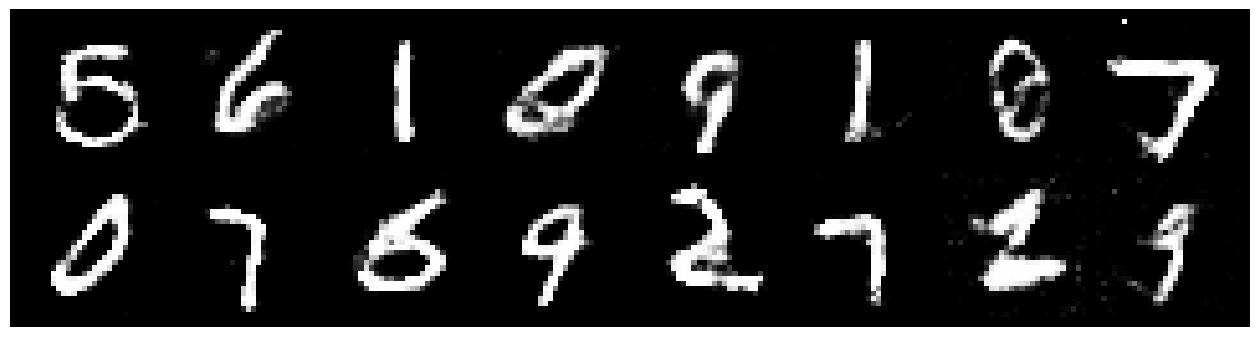

Epoch: [199/200], Batch Num: [500/600]
Discriminator Loss: 1.2958, Generator Loss: 0.8684
D(x): 0.5625, D(G(z)): 0.4670


In [ ]:
# Main training loop: iterate epochs and minibatches, update D then G, and log progress
logger = Logger(model_name="VGAN", data_name="MNIST")

for epoch in range(num_epochs):
    for n_batch, (real_batch, _) in enumerate(data_loader):
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        if torch.cuda.is_available():
            real_data = real_data.cuda()
        # Generate fake data from generator and detach so gradients don't flow into G here
        fake_data = generator(noise(real_data.size(0))).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = train_discriminator(
            d_optimizer, real_data, fake_data
        )

        # 2. Train Generator
        # Generate fake data (this time we don't detach because we want gradients to flow to G)
        fake_data = generator(noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress periodically
        if (n_batch) % 100 == 0:
            display.clear_output(True)
            # Display Images generated from the fixed test noise
            test_images = vectors_to_images(generator(test_noise)).data.cpu()
            logger.log_images(
                test_images, num_test_samples, epoch, n_batch, num_batches
            )
            # Display status Logs
            logger.display_status(
                epoch,
                num_epochs,
                n_batch,
                num_batches,
                d_error,
                g_error,
                d_pred_real,
                d_pred_fake,
            )
        # Model Checkpoints: save model state each iteration (logger decides cadence)
        logger.save_models(generator, discriminator, epoch)